# Render your design to Ansys

This notebook describes methods to directly interact with the renderer. As a designer, you might prefer this degree of control. Alternatively, you can decide to only interact with the Analysis modules (described in the 4.* tutorial notebooks) which will take care of some of these operations for you. they also provide a level of abstraction for which you will not need to learn the separate renderers, but seemlesly utilize any of them.

## Prerequisite
You need to have Ansys installed locally (any version) - at the time of this notebook, Ansys is only supported in Windows.

## 1. Create the design in Metal
#### 1.1 Preload libraries and classes, then open Metal
Let's start by importing all the key libraries and classes, and opening Metal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, MetalGUI
from qiskit_metal import Dict, Headings

In [3]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [4]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

#### 1.2 Prepare a design consisting of 4 qubits and 4 CPWs
First we import the necessary components and change key global variables to the desired size.

In [5]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [6]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

Let's create the 4-Qubit-4-CPWs design in one shot. Feel free to break the cell below into subcells if you would like to more closely follow the layout generation.

In [7]:
# Enable overwrite, so that we can re-un this cell multiple times without incurring object name collisions
design.overwrite_enabled = True

# We now define the same custom options for all the transmons.
# We only list the options we intend to modify with respect to the default values
options = Dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 3 connection_pads
    connection_pads=Dict(
        a = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

# Create the 4 transmons
q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

# Now we do the same for the CPWs
options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

# We define a handy method to shorten the number of line of code necessary to define the 4 CPW
def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

# Create the 4 CPWs
asym = 140
cpw1 = connect('cpw1', 'Q1', 'c', 'Q2', 'b', '5.6 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q2', 'c', '5.7 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'c', 'Q4', 'b', '5.6 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'c', '5.7 mm', f'-{asym}um', flip=True)

# Render the entire design to the Qiskit Metal GUI
gui.rebuild()
gui.autoscale()

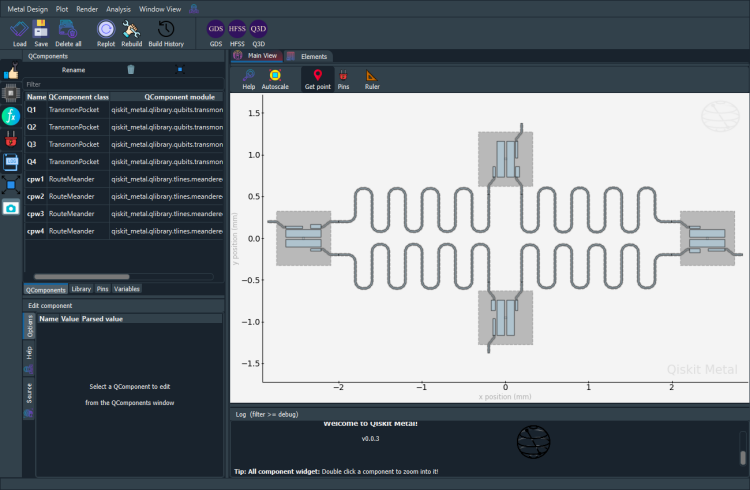

In [8]:
gui.screenshot()

## 2. Render into Ansys HFSS
The Ansys HFSS renderer was instantiated during the boot of Qiskit Metal. Let's create a short handle to refer to it in the rest of this notebook.

In [9]:
fourq_hfss = design.renderers.hfss

#### 2.1 Connect to or create an Ansys project
To setup the project **manually**, follow these instructions:
1. Launch `ANSYS Electronics Desktop yyyy Rx` (from your Windows Start menu).
2. Create a new Ansys project by clicking on the `New` icon at the top left. (or open an existing project)

Alternatively, you can **automatically** set up Ansys by executing the following cell. If Ansys is already open, executing this cell will connect this jupyter notebook session to the currently open windo, project, design and setup. you can modify that later.

In [10]:
fourq_hfss.start()

INFO 04:08PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:08PM [load_ansys_project]: 	Opened Ansys App
INFO 04:08PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 04:08PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project22
INFO 04:08PM [connect_design]: No active design found (or error getting active design).
INFO 04:08PM [connect]: 	 Connected to project "Project22". No design detected


True

#### 2.2 Setup an Ansys HFSS design
You can either create a new design or select and use an old one.

##### Creating a design

To create a new design **manually**, go to the Ansys GUI and follow these instructions:
1. Select the project from the leftmost menu in the Ansys GUI.
2. Go into the menu `Project` and select `Insert HFSS Design`.
3. Change the HFSS design to either eigenmode or modal by right-clicking on the HFSSdesign1 that just got created inside your project (left panel) and then selecting: `Solution Type...`.

To create a new design **automatically**, execute one of the following two cells. The first will create a design with eigenmode solution type, the second one will create a design with drivenmodal solution type.

NOTE: The design will be added to the project that was active when the command `fourq_hfss.start()` was executed.
Note: If a design named `HFSSTransmonQubit` already exists in the project, a new design will be created, with the name suffixed with an incremental integer: `HFSSTransmonQubit1`, `HFSSTransmonQubit2`, etc.

In [11]:
ansys_design = fourq_hfss.new_ansys_design("HFSSMetalEigenmode", 'eigenmode')
ansys_design.name

INFO 04:09PM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode [Solution type: Eigenmode]
WARNING 04:09PM [connect_setup]: 	No design setup detected.
WARNING 04:09PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


'HFSSMetalEigenmode'

In [12]:
ansys_design = fourq_hfss.new_ansys_design("HFSSMetalDrivenModal", 'drivenmodal')
ansys_design.name

INFO 04:09PM [connect_design]: 	Opened active design
	Design:    HFSSMetalDrivenModal [Solution type: DrivenModal]
WARNING 04:09PM [connect_setup]: 	No design setup detected.
WARNING 04:09PM [connect_setup]: 	Creating drivenmodal default setup.
INFO 04:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


'HFSSMetalDrivenModal'

##### Selecting a design previously created

If you created a design with the above commands, it will be automatically selected and linked to this jupyter notebook session. Instead, if you want to use a design that had been created beforehand in the project, you can select it by following one of following three approaches:
* manually activating the design from the Ansys GUI, **before** you run the `fourq_hfss.start()` command. In the Ansys GUI, you will find the list of designs in the leftmost panel, and you can activate them with a double click.
* using method `fourq_hfss.connect_ansys(*with parameters*)`, specifying which design to connect to.
* using method `activate_ansys_design('name')`.

The next two cells exemplify how to use the last method. We will switch between the two designs that we previously created.

NOTE: this method will also create a design with the given name if the design name is not found, to be able to create a new design it will need to be given the solution type, for example: `fourq_hfss.activate_ansys_design("newEigen", 'eigenmode')`. Failure to specify the type will result in an error message asking to specify the the `solution_type` parameter.

In [13]:
fourq_hfss.activate_ansys_design("HFSSMetalEigenmode")

INFO 04:09PM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode [Solution type: Eigenmode]


In [14]:
fourq_hfss.activate_ansys_design("HFSSMetalDrivenModal")

INFO 04:09PM [connect_design]: 	Opened active design
	Design:    HFSSMetalDrivenModal [Solution type: DrivenModal]


#### 2.3 Render some component from the Metal design

Find below several rendering examples. You can choose to only execute one of them if you are just browsing this notebook.

Notice how we explicitly clear the design before re-rendering. Indeed `render_design()` only adds shapes to the Ansys design. Re-rendering the same shapes will cause violations.

In [15]:
fourq_hfss.render_design()  # entire Metal design.

In [16]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q1'], [('Q1', 'b'), ('Q1', 'c')])  # single qubit with 2 endcaps.

In [17]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q1', 'cpw1', 'Q2'], [('Q1', 'b'), ('Q2', 'c')])  # 2 qubits and 2 endcaps, one per qubit.

For Driven-Modal analysis, we can also add terminations. In the example below we render 1 qubit with 1 endcap and 1 port with a 70 Ohm termination.

In [18]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q2'], [('Q2', 'a')], [('Q2', 'b', '70')])

In the previous examples, rendering area dimensions is determined by the size of the selected geometries, with some buffer.

For a more accurate control of the chip size, you need to disable the buffering as below. This will use `design._chips['main']['size']` to determine the rendering area dimensions.

In [19]:
design._chips['main']['size']['size_y'] = '6mm'

In [20]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design([], [], box_plus_buffer=False)

You can also modify the chip size directly by updating `design._chips['main']['size']`. Example below.

NOTE: we purposfully make the chip size smaller than the size of the geometry. This will cause a warning to show which will need to be fixed by the user intending to conduct a valid analysis.

In [21]:
fourq_hfss.clean_active_design()
design._chips['main']['size']['size_x'] = '4mm'
fourq_hfss.render_design([], [], box_plus_buffer=False)

In [22]:
#    Return back to original size, for the remainder of the notebook
design._chips['main']['size']['size_x'] = '6mm'

#### 2.4 Create of select a setup
This section is only needed if you plan to execute an analysis. This topic will be covered in the tutorial notebooks 4.x.

To **select** a setup for the active design, you can use `activate_ansys_setup()`. If the setup exists, the QRenderer will reference the setup, otherwise, will make a new setup with the name give.  If no name given, the default name of "Setup" will be used.

In [23]:
fourq_hfss.activate_ansys_setup('SetupNEW')

04:11PM 12s WARNING [activate_ansys_setup]: The setup_name=SetupNEW was not in active design.  Setups in active design are: 
('Setup',).  A new setup will default values will be added to the design.  


**Finally** disconnect the Metal renderer from the Ansys session.

NOTE: If you do not disconnect explicitly, you might not be able to close the Ansys GUI later.

In [24]:
fourq_hfss.stop()

True

## 3. Render into Ansys Q3D
The Ansys Q3D renderer was instantiated during the boot of Qiskit Metal. Let's create a short handle to refer to it in the rest of this notebook.

In [25]:
fourq_q3d = design.renderers.q3d

#### 3.1 Connect to or create an Ansys project
See section 2.1 in this notebook for additional details and options.

In [26]:
fourq_q3d.start()

INFO 04:11PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:11PM [load_ansys_project]: 	Opened Ansys App
INFO 04:11PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 04:11PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project22
INFO 04:11PM [connect_design]: 	Opened active design
	Design:    HFSSMetalDrivenModal [Solution type: DrivenModal]
INFO 04:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 04:11PM [connect]: 	Connected to project "Project22" and design "HFSSMetalDrivenModal" 😀 



True

#### 3.2 Setup an Ansys Q3D design
You can either create a new design or select and use an old one.

##### Creating a design

To create a new design **manually**, go to the Ansys GUI and follow these instructions:
1. Select the project from the leftmost menu in the Ansys GUI.
2. Go into the menu `Project` and select `Insert Q3D Extractor Design`.

To create a new design **automatically**, execute the following cell.

NOTE: If a design named `Q3dMetalDesign` already exists in the project, a new design will be created, with the name suffixed with an incremental integer: `Q3dMetalDesign1`, `Q3dMetalDesign2`, etc.

In [27]:
ansys_design = fourq_q3d.new_ansys_design("Q3dMetalDesign", 'capacitive')
ansys_design.name

INFO 04:11PM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesign [Solution type: Q3D]
WARNING 04:11PM [connect_setup]: 	No design setup detected.
WARNING 04:11PM [connect_setup]: 	Creating Q3D default setup.
INFO 04:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


'Q3dMetalDesign'

##### Selecting a design previously created

If you created a design with the above commands, it will be automatically selected and linked to this jupyter notebook session. Instead, if you want to use a design that had been created beforehand in the project, you can select it by following one of following three approaches:
* manually activating the design from the Ansys GUI, **before** you run the `fourq_hfss.start()` command. In the Ansys GUI, you will find the list of designs in the leftmost panel, and you can activate them with a double click.
* using method `fourq_q3d.connect_ansys(*with parameters*)`, specifying which design to connect to.
* using method `fourq_q3d.activate_ansys_design('name')`.

The next two cells exemplify how to use the last method. The first of the two cells below will create a new design because the name does not corrispond to any design in the project. The second cell will return to the previously created design.

NOTE: this method will also create a design with the given name if the design name is not found, to be able to create a new design it will need to be given the solution type, for example: `fourq_hfss.activate_ansys_design("newEigen", 'eigenmode')`. Failure to specify the type will result in an error message asking to specify the the `solution_type` parameter.

In [28]:
fourq_q3d.activate_ansys_design("Q3dMetalDesignNEW", 'capacitive')

04:11PM 14s WARNING [activate_ansys_design]: The design_name=Q3dMetalDesignNEW was not in active project.  Designs in active project are: 
['HFSSMetalEigenmode', 'Q3dMetalDesign', 'HFSSMetalDrivenModal'].  A new design will be added to the project.  
INFO 04:11PM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesignNEW [Solution type: Q3D]
WARNING 04:11PM [connect_setup]: 	No design setup detected.
WARNING 04:11PM [connect_setup]: 	Creating Q3D default setup.
INFO 04:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


In [29]:
fourq_q3d.activate_ansys_design("Q3dMetalDesign")

INFO 04:11PM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesign [Solution type: Q3D]


#### 3.3 Render some component from the Metal design

Find below several rendering examples. You can choose to only execute one of them if you are just browsing this notebook.

Notice how we explicitly clear the design before re-rendering. Indeed `render_design()` only adds shapes to the Ansys design. Re-rendering the same shapes will cause violations.

In [30]:
fourq_q3d.render_design()  # entire Metal design.

In [31]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design(['Q1'], [('Q1', 'b'), ('Q1', 'c')])  # single qubit with 2 endcaps.

In [32]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design(['Q1', 'cpw1', 'Q2'], [('Q1', 'b'), ('Q2', 'c')])  # 2 qubits and 2 endcaps, one per qubit.

In the previous examples, rendering area dimensions is determined by the size of the selected geometries, with some padding.

For a more accurate control of the chip size, you need to disable the buffering as below. This will use `design._chips['main']['size']` to determine the rendering area dimensions.

In [33]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design([], [], box_plus_buffer=False)

You can also modify the chip size directly by updating `design._chips['main']['size']`. Example below:

In [34]:
fourq_q3d.clean_active_design()
design._chips['main']['size']['size_y'] = '4mm'
fourq_q3d.render_design([], [], box_plus_buffer=False)

In [35]:
#    Return back to original size, for the remainder of the notebook
design._chips['main']['size']['size_y'] = '6mm'

#### 3.4 Create of select a setup
This section is only needed if you plan to execute an analysis. This topic will be covered in the tutorial notebooks 4.x.

To **select** a setup for the active design, you can use `activate_ansys_setup()`. If the setup exists, the QRenderer will reference the setup, otherwise, will make a new setup with the name give.  If no name given, the default name of "Setup" will be used.

In [36]:
fourq_q3d.activate_ansys_setup("SetupNEW")

04:13PM 53s WARNING [activate_ansys_setup]: The setup_name=SetupNEW was not in active design.  Setups in active design are: 
('Setup',).  A new setup will default values will be added to the design.  


**Finally** disconnect the Metal renderer from the Ansys session.

NOTE: If you do not disconnect explicitly, you might not be able to close the Ansys GUI later.

In [37]:
fourq_q3d.stop()

True

If you want to close the Metal GUI, uncomment the following cell

In [38]:
# gui.main_window.close()

## References - Miscellaneous pyEPR/Ansys commands
The following commands are for reference only to better understand how the backend code works. They're not meant to be run directly in this notebook as part of the tutorial.

import pyEPR as epr

Connect to Ansys directly from notebook:

pinfo = epr.ProjectInfo(project_path = None, 
                        project_name = None,
                        design_name  = None)
modeler = pinfo.design.modeler

Access methods within HfssDesign class in pyEPR:

epr.ansys.HfssDesign.create_dm_setup
epr.ansys.HfssDesign.create_q3d_setup

Get project and design names:

pinfo.project_name
design._design.GetName()

Filter qgeometry table:

full_table = design.qgeometry.tables['poly']
mask = full_table['subtract'] == False
table = full_table[mask]

Draw centered rectangles:

bigsquare = modeler.draw_rect_center([0, 0, 0], x_size=8, y_size=8, name='bigsquare')
topright = modeler.draw_rect_center([2, 2, 0], x_size=2, y_size=2, name='topright')

Subtracting shapes:

modeler.subtract('bigsquare', ['topright'])

Draw centered box:

modeler.draw_box_center([0, 0, 0], [1, 2, 3])

Draw closed polygon:

trianglepts = [[-1, 5, 0], [1, 5, 0], [0, 7, 0]]
modeler.draw_polyline(trianglepts, closed=True)

Draw polyline:

smallpts = [[2.85, 0, 0], [3.15, 0, 0]]
modeler.draw_polyline(smallpts, closed=False)

Sweep one polyline with another:

modeler._sweep_along_path('Polyline8', 'Polyline7')